## Import Libraries

In [55]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [56]:
df = pd.read_csv(r"C:\Users\Yasserkm\Desktop\Bootcamp-V8\Usecases\Usecase-4\data\data_saudi_used_cars.csv")

In [57]:
df.shape

(5624, 11)

In [58]:
df.head(2)

Type  Region    Make  Gear_Type Origin   Options  Year  Engine_Size  \
0  Corolla    Abha  Toyota     Manual  Saudi  Standard  2013          1.4   
1    Yukon  Riyadh     GMC  Automatic  Saudi      Full  2014          8.0   

   Mileage  Negotiable   Price  
0   421000        True       0  
1    80000       False  120000

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [59]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

Empty DataFrame
Columns: [Type, Region, Make, Gear_Type, Origin, Options, Year, Engine_Size, Mileage, Negotiable, Price]
Index: []

In [60]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [61]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [62]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [63]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

In [64]:
df = df[df['Year']>=2000]

In [65]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [66]:
df.shape

(5364, 11)

In [67]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [68]:
df.shape

(5364, 11)

In [69]:
#df[df['Type']=='Other']

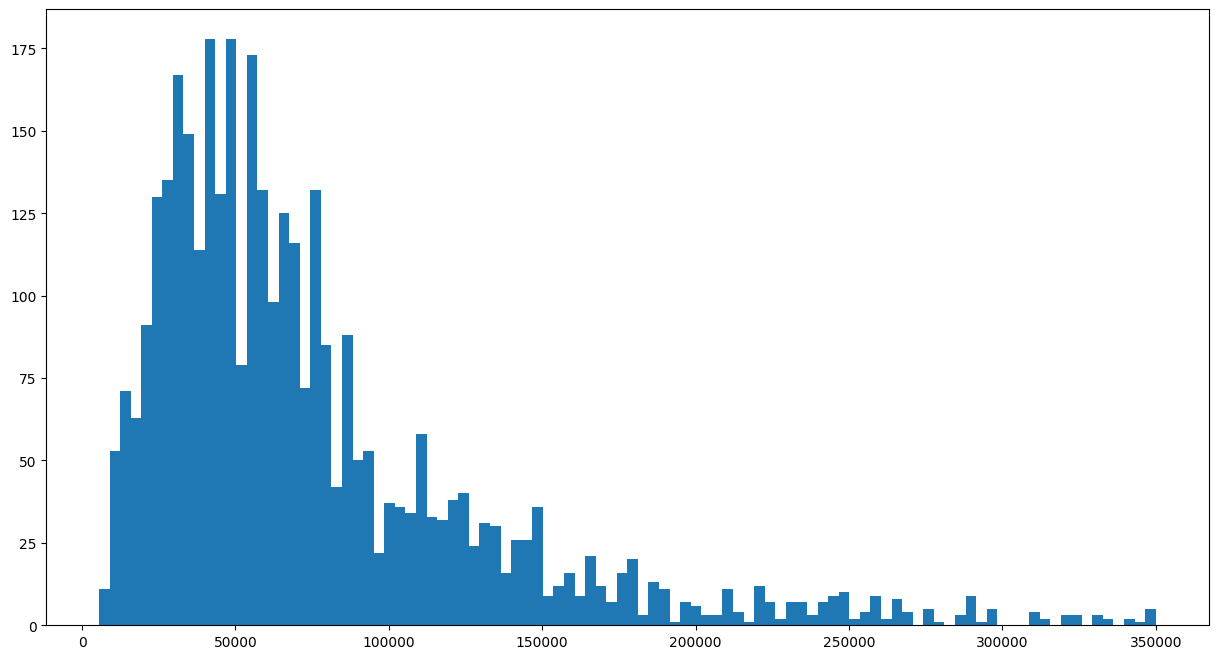

In [70]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [71]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [72]:
df.shape

(3566, 11)

In [73]:
#df[df['Mileage']<1000]

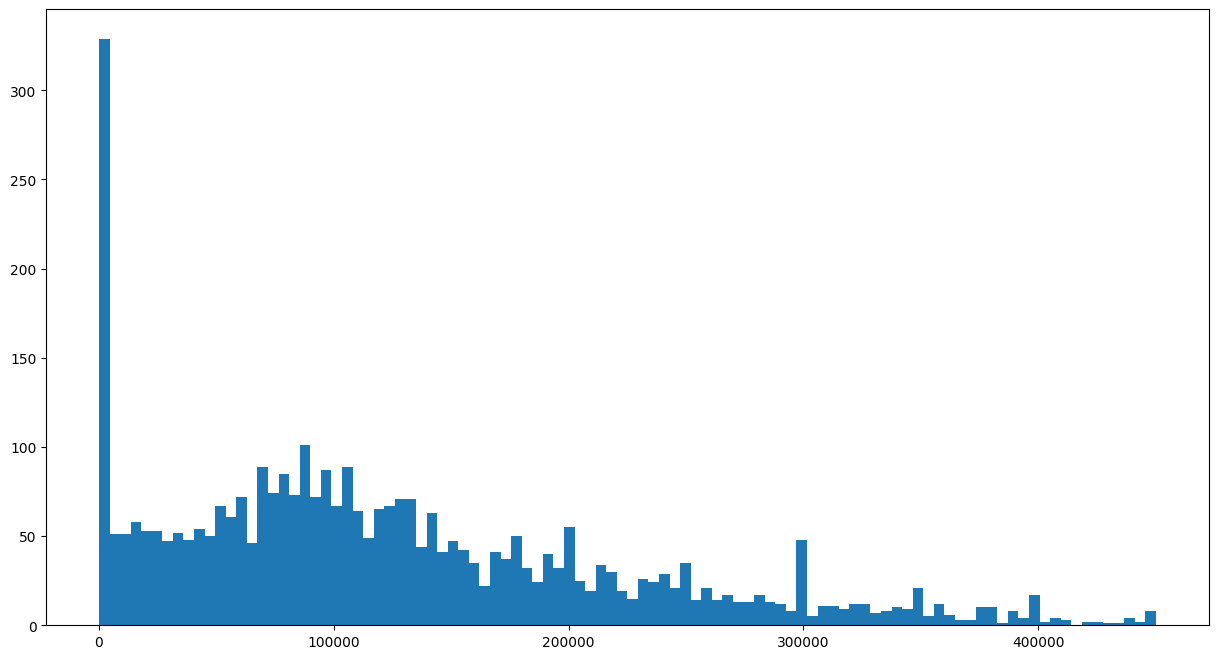

In [74]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [75]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [76]:
df.head(2)

Type  Region        Make  Gear_Type       Origin Options  Year  \
1        Yukon  Riyadh         GMC  Automatic        Saudi    Full  2014   
2  Range Rover  Riyadh  Land Rover  Automatic  Gulf Arabic    Full  2015   

   Engine_Size  Mileage  Negotiable   Price  
1          8.0    80000       False  120000  
2          5.0   140000       False  260000

In [77]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [78]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [79]:
df.shape

(3511, 325)

In [80]:
df.head(2)

Year  Engine_Size  Mileage  Negotiable   Price  Type_3  Type_300  \
1  2014          8.0    80000       False  120000   False     False   
2  2015          5.0   140000       False  260000   False     False   

   Type_3008  Type_301  Type_5  ...  Make_Zhengzhou  Gear_Type_Automatic  \
1      False     False   False  ...           False                 True   
2      False     False   False  ...           False                 True   

   Gear_Type_Manual  Origin_Gulf Arabic  Origin_Other  Origin_Saudi  \
1             False               False         False          True   
2             False                True         False         False   

   Origin_Unknown  Options_Full  Options_Semi Full  Options_Standard  
1           False          True              False             False  
2           False          True              False             False  

[2 rows x 325 columns]

In [81]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['Price'].quantile(0.35)
p75 = df['Price'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['car_price_category'] = df['Price'].apply(categorize_price)

df.drop('Price', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['car_price_category'].value_counts())

car_price_category
Good_Price     1404
Cheap_Price    1227
High_Price      880
Name: count, dtype: int64


In [82]:
p35, p75

(46000.0, 95000.0)

In [83]:
df['car_price_category'] 

1        High_Price
2        High_Price
3       Cheap_Price
5        Good_Price
6        Good_Price
           ...     
5616     High_Price
5618     Good_Price
5619     Good_Price
5621     High_Price
5622     High_Price
Name: car_price_category, Length: 3511, dtype: object

In [84]:
encoder = LabelEncoder()
df['car_price_category_encoded'] = encoder.fit_transform(df['car_price_category'])  

#### 3. Feature selection

In [85]:
# sns.heatmap(df.corr(), annot=True);

In [86]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['car_price_category_encoded'].sort_values(ascending=False))

car_price_category_encoded    1.000000
Year                          0.407525
Engine_Size                   0.334464
Options_Full                  0.305622
Make_Mercedes                 0.225376
                                ...   
Make_Hyundai                 -0.223059
Type_Accent                  -0.237844
Options_Standard             -0.283697
Mileage                      -0.287567
Negotiable                         NaN
Name: car_price_category_encoded, Length: 325, dtype: float64


In [87]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['car_price_category_encoded']) > \
threshold]['car_price_category_encoded'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
       'car_price_category_encoded'],
      dtype='object')

In [88]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
                      'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
                      'car_price_category_encoded']

In [89]:
df = df[selected_features]
df.head()

Year  Engine_Size  Mileage  Type_Accent  Type_Land Cruiser  Make_Hyundai  \
1  2014          8.0    80000        False              False         False   
2  2015          5.0   140000        False              False         False   
3  2015          2.4   220000        False              False         False   
5  2019          2.0    25000        False              False         False   
6  2012          4.8   189000        False              False         False   

   Make_Mercedes  Options_Full  Options_Standard  car_price_category_encoded  
1          False          True             False                           2  
2          False          True             False                           2  
3          False         False             False                           0  
5          False         False             False                           1  
6          False          True             False                           1

#### 4. Prepare train and test data

In [90]:
# Prepare data
X = df.drop(['car_price_category_encoded'], axis=1)
y = df['car_price_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
X.shape

(3511, 9)

## Buliding the Model

In [92]:
model = LogisticRegression()

## Train the Model

In [93]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [94]:
# Predict and evaluate the model
y_pred_test = model.predict(X_test_scaled)

## Interpretation of the Model

In [95]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

Coefficient
Year                  2.062215
Engine_Size           1.308080
Mileage              -0.387086
Type_Accent          -0.300574
Type_Land Cruiser     0.732347
Make_Hyundai         -0.534238
Make_Mercedes         0.640428
Options_Full          0.381116
Options_Standard     -0.372942

In [96]:
model.coef_

array([[-2.01036584e+00, -1.27941175e+00,  2.45085082e-01,
         5.65943385e-01, -7.31770269e-01,  2.85405565e-01,
        -5.27108405e-01, -3.32076490e-01,  3.44569387e-01],
       [-5.18492746e-02, -2.86684821e-02,  1.42000914e-01,
        -2.65369578e-01, -5.76452034e-04,  2.48832315e-01,
        -1.13319860e-01, -4.90399043e-02,  2.83721630e-02],
       [ 2.06221512e+00,  1.30808023e+00, -3.87085996e-01,
        -3.00573806e-01,  7.32346721e-01, -5.34237880e-01,
         6.40428265e-01,  3.81116394e-01, -3.72941550e-01]])

In [97]:
print(model.intercept_) 

[ 0.11751288  0.95092615 -1.06843903]


## Evaluating the Model 

In [98]:
# our benchmark model
base_model = round(df['car_price_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

39.99

1. Accuracy

In [99]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy_Train = accuracy_score(y_train, y_pred_train)
accuracy_Train

0.7133190883190883

In [100]:
# Test score
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test

0.7226173541963016

- Confusion matrix

In [101]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix

array([[166,  73,   4],
       [ 33, 205,  42],
       [  2,  41, 137]], dtype=int64)

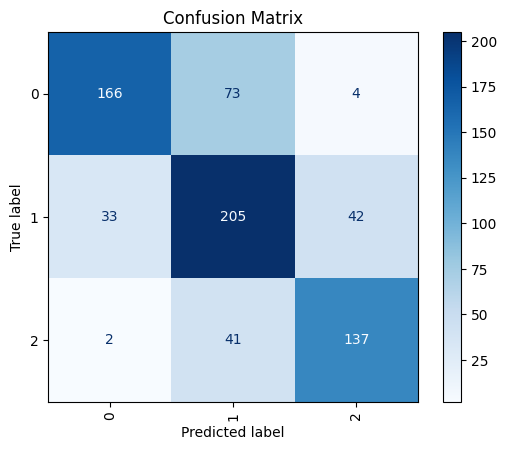

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

2. Precision

In [103]:
# Train score
precision_train = precision_score(y_train, y_pred_train, average='macro')
print(f"Precision in train: {precision_train:.2f}")

# Test score
precision_test = precision_score(y_test, y_pred_test, average='macro')
print(f"Precision in test: {precision_test:.2f}")

Precision in train: 0.73
Precision in test: 0.74


3. Recall

In [104]:
# Train score
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Recall in train: {recall_train:.2f}")

# Test score
recall_test = recall_score(y_test, y_pred_test, average='macro')
print(f"Recall in test: {recall_test:.2f}")

Recall in train: 0.71
Recall in test: 0.73


4. F1-Score

In [106]:
# Train score
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"f1-score in train: {f1_train:.2f}")

# Test score
f1_test = precision_score(y_test, y_pred_test, average='macro')
print(f"f1-score in test: {f1_test:.2f}")

f1-score in train: 0.72
f1-score in test: 0.74


- Classification report

In [107]:
from sklearn.metrics import classification_report

print('Train report: ')
print(classification_report(y_train, y_pred_train))

print('Test report: ')
print(classification_report(y_test, y_pred_test))

Train report: 
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       984
           1       0.63      0.74      0.68      1124
           2       0.77      0.71      0.74       700

    accuracy                           0.71      2808
   macro avg       0.73      0.71      0.72      2808
weighted avg       0.72      0.71      0.72      2808

Test report: 
              precision    recall  f1-score   support

           0       0.83      0.68      0.75       243
           1       0.64      0.73      0.68       280
           2       0.75      0.76      0.75       180

    accuracy                           0.72       703
   macro avg       0.74      0.73      0.73       703
weighted avg       0.73      0.72      0.72       703

